In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import numpy as np
import os, glob
import requests
import geopandas as gp
from shapely.geometry import Point

In [4]:
# build geometry
def create_geom(x):
    point = Point(x['longitude'],x['latitude'])
    return point

def get_station_locations():
    site = 'https://data.ny.gov/resource/7i2s-kiup.json'
    
    # This list was created manually
    site_names = ['JHS 45', 'IS 143','PS 19','Division Street','CCNY','Morrisania II','IS 52'
            ,'IS 74', 'Pfizer Lab', 'PS 314', 'JHS 126', 'PS 274', 'Maspeth','Queens College'
            ,'Susan Wagner HS','Port Richmond', 'Fresh Kills West']
    
    # request data from api
    r = requests.get(site)
    # convert to dataframe
    df = pd.DataFrame(r.json())
    
    # subset based on the region
    df = df[df['region'] == '2']
    df['site_name'] = site_names
    
    # build geometry
    df.loc[:,'longitude'] = df['longitude'].astype(float)
    df.loc[:,'latitude'] = df['latitude'].astype(float)    
    df['geometry'] = df.apply(create_geom, axis=1) 
    
    return df[['site_name','latitude','longitude', 'geometry']]

def read_data():
    aq_list = !ls '../../../Data/NYC_AQ/'*.csv

    df1 = []
    for i in aq_list:
        df = pd.read_csv(i)
        df1.append(df)

    data = pd.concat(df1)    
    data['timestamp'] = pd.to_datetime(data['Date(YYYY-MM-DD)'] + ' ' + data['Time (HH24:MI)'])
    data.index = data['timestamp']
    data = data.sort_index()
    data.drop(['timestamp','Date(YYYY-MM-DD)', 'Time (HH24:MI)'], axis=1, inplace=True)
    
    # clean up column names
    data.columns = data.columns.map(lambda x: " ".join(x.split(' ')[:-2]))    
    
#     station_locations = get_station_locations()
#     dec_stations = station_locations[station_locations['site_name'].isin(data.columns)][cols]
    
#     # remove some crazy outlier
#     data['IS 52']['2015-02-05 13:00:00'] = np.nan
#     data['IS 52']['2016-02-24 12:00:00'] = np.nan
#     data['Port Richmond']['2007':'2010'] = np.nan
    
#     return data, dec_stations
    return data
    
data = read_data()

In [10]:
data['2014':'2016'].describe()

,PS 274,IS 74,PS 314,Maspeth,IS 52,IS 143,Division Street,Fresh Kills West,Queens College,CCNY,PS 19,Port Richmond
count,20899.000000,19822.000000,21255.000000,21108.000000,17623.000000,20287.000000,20898.000000,19525.000000,17711.000000,20145.000000,21039.000000,19126.000000
mean,7.077544,8.115695,7.239572,7.687109,7.010268,9.693858,8.697177,7.925680,7.266539,8.037027,9.001412,8.715612
std,5.510734,6.031042,5.471453,5.925159,6.419160,6.715815,5.932834,5.579023,5.831413,5.756123,6.436815,6.237430
min,-4.900000,-4.900000,-4.900000,-4.800000,-169.840000,-4.500000,-8.200000,-2.700000,-17.730000,-0.700000,-4.800000,-9.100000
25%,3.200000,3.900000,3.500000,3.500000,2.870000,4.800000,4.600000,3.900000,3.270000,4.000000,4.500000,4.500000
50%,6.300000,7.100000,6.300000,6.700000,5.620000,8.400000,7.800000,6.800000,5.830000,7.000000,7.900000,7.700000
75%,10.000000,11.100000,10.000000,10.900000,9.870000,13.200000,11.800000,10.700000,9.920000,10.800000,12.200000,11.900000
max,70.000000,97.100000,80.900000,68.500000,67.920000,61.800000,86.600000,60.700000,44.750000,175.800000,98.800000,75.800000


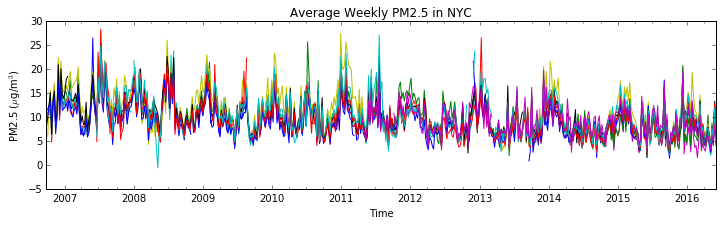

In [219]:
def plot_inspect():
    fig, ax = plt.subplots(figsize=(12,3))
    data['2006-10':].resample('W').mean().plot(legend=False, ax=ax)
    plt.title('Average Weekly PM2.5 in NYC')
    plt.xlabel('Time')
    plt.ylabel('PM2.5 ($\mu$g/m$^3$)')
    
plot_inspect()

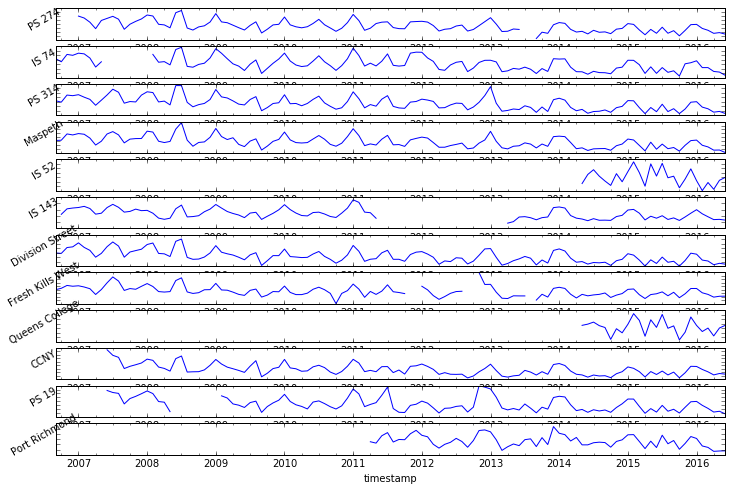

In [234]:
def plot_inspect_stations():
    fig, ax = plt.subplots(12, 1, figsize=(12,8))
    for i in range(data.shape[1]):
        data.iloc[:,i].resample('M').mean().plot(ax=ax[i])
        ax[i].set_ylabel(data.columns[i], rotation=30)
        ax[i].set_yticklabels('')
        
plot_inspect_stations()

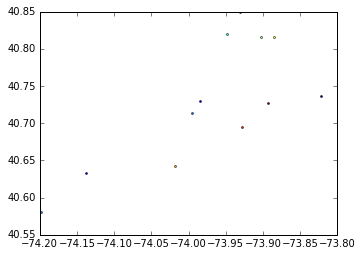

In [195]:
def plot_station_locations(data):
    gdf = gp.GeoDataFrame(data, crs={"init":"espg:4326"})
    gdf.reset_index(drop=True, inplace=True)
    gdf.plot()
    #sites.to_file('../data/dec_sites/dec_sites.shp')
    
plot_station_locations(dec_stations)

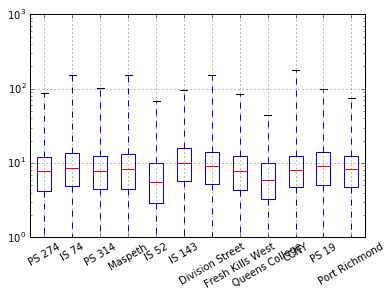

In [250]:
def site_compare():
    data.boxplot(figsize=(6,4), whis='range', boxprops={'linestyle':None}, rot=30)
    plt.yscale('log')
site_compare()

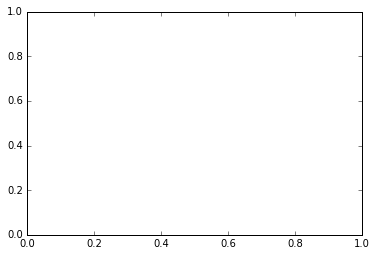

In [312]:
def hourly():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    df = []
    for ind, val in data['Division Street'].groupby([data.index.dayofweek]):
        df.append(val.values)
    
    return df
        
l = hourly()

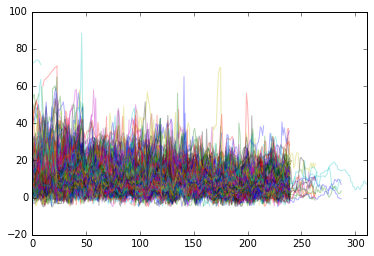

In [267]:
def some_plot():
    fig, ax = plt.subplots()

    for ind, val in data.groupby([data.index.dayofyear]):
        val['PS 274'].reset_index().plot(ax=ax, label=ind, alpha=0.3, legend=False)
    
some_plot()

---

---

In [292]:
def compute_diurnal(x):
    df = []
    for ind, val in x.groupby([x.index.dayofyear]):
        df.append(val.values)        
    df1 = pd.DataFrame(df).mean(axis=0)    
#     idx = pd.date_range('2000-01-01 00:00:00', '2000-01-08 00:00:00', freq='H')
#     df1.index = idx[:-1]
    return df1

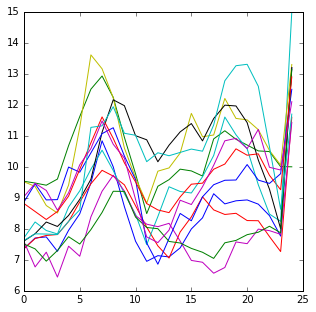

In [293]:
def diurnal():
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    for i in range(12):
        df = data['2015-11':'2015-12'].iloc[:,i]
        df = compute_diurnal(df)
        ax.plot(df)
#         ax[i].set_ylim(0,60)
#         if i != 11:
#             ax[i].set_xticklabels('')
diurnal()

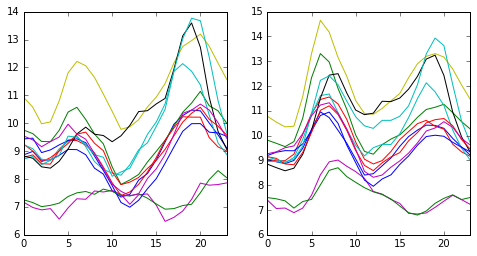

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for i in data.columns:
    weekend = data[i][data[i].index.dayofweek >= 5]
    weekday = data[i][data[i].index.dayofweek < 5]    

    station_mean_we = []
    station_mean_wd = []    
    for ind, val in weekend.groupby([weekend.index.hour]):
        station_mean_we.append(val.mean())
        
    for ind, val in weekday.groupby([weekday.index.hour]):
        station_mean_wd.append(val.mean())        
        
    ax[0].plot(np.array(station_mean_we))
    ax[1].plot(np.array(station_mean_wd))
    
    ax[0].set_xlim(0,23)
    ax[1].set_xlim(0,23)

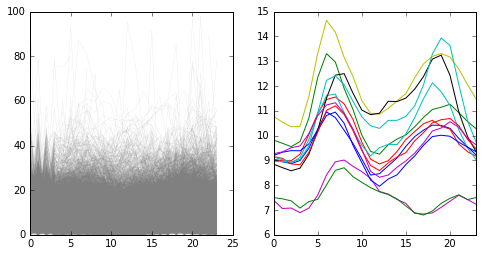

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

for i in data.columns:
    weekend = data[i][data[i].index.dayofweek >= 5]
    weekday = data[i][data[i].index.dayofweek < 5]    

    station_mean_we = []
    station_mean_wd = []    
    for ind, val in weekend.groupby([weekend.index.hour]):
        #ax[0].plot(val.values)
        station_mean_we.append(val.values)
        
    df = pd.DataFrame(station_mean_we)
    for ind, val in weekday.groupby([weekday.index.hour]):
        station_mean_wd.append(val.mean())        

    ax[0].plot(df, lw=0.3, color='grey', alpha=0.2)
    ax[1].plot(np.array(station_mean_wd))
    
    #ax[0].set_xlim(0,23)
    ax[1].set_xlim(0,23)

In [11]:
aq_std = data.apply(np.std, axis=1)
#aq_var = data.apply(np.var, axis=1)

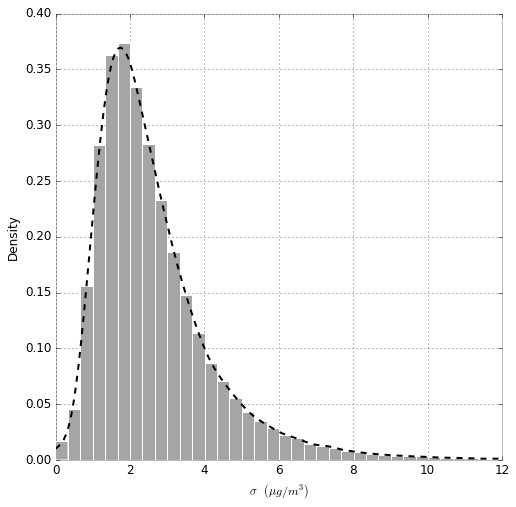

In [80]:
#fig, ax = plt.subplots(figsize=(8,8))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

aq_std.plot(kind='kde', ax=ax, lw='2', style='--', color='black', zorder=4, fontsize=12)
aq_std.hist(bins=100, ax=ax, color='#A5A5A5', normed=True, zorder=3, xlabelsize=12)
ax.set_xlim(0,12)
ax.grid(True)
ax.set_xlabel('$\sigma$  $(\mu g/m^3)$')
fig.savefig('../std_all_sites.pdf', dpi=300, bbox_inches='tight')